In [1]:
import numpy as np
import matplotlib.pyplot as plt

hP = 6.6260688e-27 # Planck's const / erg s
hbar = hP/2*np.pi
G = 6.67384e-8 # cm^3/g/s^2
c = 2.99792458e10 # speed of light  / cm/s
kB = 1.3806488e-16 # Boltzmann const / erg/K
mH = 1.66053892e-24 # atomic mass unit / g
me = 9.1093898e-28 # electron mass / g
mp = 1.676e-24 #proton mass [g] 
mu = 0.615 #mean molecular weight
alphaEM = 1/137.0359895 # fine structure constant
sigmaT = 8*np.pi/3*(alphaEM*hbar/me/c)**2 # Thomson cross section / cm^2
a_rad =  np.pi**2/15*kB*(kB/hbar/c)**3 # radiation const / erg/cm^3/K^4
stefan = a_rad*c/4 # Stefan-Boltzmann const / erg/cm^2/s/K^4
eV = 1.60217733e-12 # 1 electron volt / erg
keV = 1e3*eV
Msun = 1.98892e33 # solar mass / g
Msun = 1.98892e33 # solar mass / g
LEsun = 4*np.pi*c*G*Msun*mH/sigmaT # Eddington luminosity / erg/s
MEsun = LEsun/c**2
pc = 3.08567758e18 # 1 parsec / cm

kappa_es = 0.4 # opacity by electron scattering / cm^2/g
kappa_0 = 6.45e22 # krammers opacity at (rho,T)=(1,1) in cgs
nu_0 = 2.4e21*15 # electron-ion coupling (Coulomb log = 15)

In [2]:
def schwarz(M):
    '''
    give M in Msuns
    out in cms
    '''
    return 2*G*(M*Msun)/(c**2)

def m_edd(M):
    '''
    give M in MSuns
    out in g/s
    '''
    epsilon = 0.1
    return (4*np.pi*G*(M)*mH)/(epsilon*c*sigmaT)


def omega(M,r):
    '''
    M in Msun
    r in rschwarz
    '''
    return (G*M*Msun/((r*schwarz(M))**3))**0.5


def domega_dr(M,r):
    '''
    M in Msun
    r in rschwarz
    '''
    return (-1.5)*(G*M*Msun/((r*schwarz(M))**5))**0.5


def d2omega_d2r(M,r):
    '''
    M in Msun
    r in rschwarz
    '''
    return (15/4)*(G*M*Msun/((r*schwarz(M))**7))**0.5

def sigma_ana(Mdot,r,r_star,nu):
    '''
    Mdot in msun/second
    r in schwarz
    r_star in schwarz
    '''
    
    return (Mdot*Msun/(3*np.pi*nu))*(1-(r_star/r)**0.5)




In [ ]:
(m_edd(1.5))*60*60*24*365

3.3910242427129244e-10

In [ ]:
def dsigma_dr(r,sigma,M,Mdot,nu):
    
    m = M*Msun
    mdot = Mdot*Msun
    R = r*schwarz(M)
    
    num = 2*mdot*R*omega(M,r) + mdot*R**2*domega_dr(M,r) - 6*np.pi*R**2*nu*sigma*domega_dr(M,r) - 2*np.pi*R**3*nu*sigma*d2omega_d2r(M,r)
    #num = 2*(r*schwarz(M))*(Mdot*Msun) + domega_dr(M,r) - 2*np.pi*nu*(r*schwarz(M))**3*sigma*d2omega_d2r(M,r) - 4*np.pi*sigma*nu*domega_dr(M,r)*(r*schwarz(M))**2
    
    den = -2*np.pi*nu*domega_dr(M,r)*R**3
    
    return np.divide(num,den)


In [3]:
 class SS:
    def __init__(self, M, M_dot, nu, r_out, r_in=3):
        """
        M = mass of black hole / solar mass
        M_dot = mass accretion rate 
        alpha = viscosity parameter (0<alpha<=1)
        r_out = radius of disk's outer edge 
        r_in = radius of disk's inner edge 

        """
        self.rg = 2*G*M*Msun/2.99792458e10**2
        self.M = M*Msun #grams
        self.M_dot = M_dot*M*MEsun #grams /s
        #self.alpha = alpha
        self.r_in = r_in*self.rg #cm
        self.r_out = r_out*self.rg
        self.nu = nu 
        self.dr = 0
        #self.H = self.p/self.sigma * (self.r_out**3)/(G*self.M)
        #self.rho = self.sigma / self.H   
        #self.r = np.geomspace(self.r_in, self.r_out, N+1)[1:]

        self.r = np.linspace(self.r_in,self.r_out,1000)
        self.H = 0.016*self.r

        self.r_boundary = 0
        #self.y = StandardModel.solve(self, self.r)
        
        #if r_out is less than 3*rg, do calculations by assuming that all values at those 'r' is 0 
        # if r_out < 3*rg:
        #   self.sigma = 0
    
        '''
        #gas pressure
        pgas = (self.rho*kB*self.Tc)/mH

        #radiation pressure
        prad = (4*sigmaT*(self.Tc)**4)/(3*c)

        #electron scattering/mp
        kappa = sigmaT/mp

        #inner disk
        if 3 < r_out < 5:
          self.p = prad
          self.kappa = kappa

        #middle disk
        if 5 < r_out < 8:
          self.p = pgas
          self.kappa = kappa

        #outer disk:
        if r_out > 8:
          self.p = pgas
          self.kappa = 6.6e22*self.rho*(self.Tc)**(-7/2)
        '''
    def get_kappa(self):

        kappa = sigmaT/mp
        self.kappa = kappa

        return self.kappa


    def analytical_middle(self,alpha):
  
        #Analytical Solution for the middle; gas pressure dominated with Kramer's Opacity
    
        m = self.M/Msun
        mdot = self.M_dot/(3e-8) * (Msun/self.M)
        r = self.r / self.rg
        
        #am i applying dimensionaless thingy twice? Make sure that the thing i am inputting has dimensions
        #and then i apply the dimensionlessing thing
        
        sigma = 1.7e5*(alpha**(-4/5))*(mdot**(3/5))*(m*(1/5))*(r**(-3/5))*(1-r**(-1/2))**(3/5) #g/cm^2
        Tc = 3.1e8*(alpha**(-1/5))*(mdot**(2/5))*(m**(-1/5))*(r**(-9/10))*(1-r**(-1/2))**(2/5) 
        H = 1.2e4*(alpha**(-1/10))*(mdot**(1/5))*(m**(1/5))*(r**(21/20))*(1-r**(-1/2))**(1/5)
        rho = 4.2e24*(alpha**(-7/10))*(mdot**(2/5))*(m**(-7/10))*(r**(-33/20))*(1-r**(-1/2))**(2/5)
        tau = 1e2*(alpha**(-4/5))*(mdot**(9/10))*(m**(1/5))*(r**(3/20))*(1-r**(-1/2))**(9/10)
        vr = 2e6**(alpha**(4/5))*(mdot**(2/5))*(m**(-1/5))*(r**(-2/5))*(1-r**(-1/2))**(-3/5)
    
        
        return (sigma,Tc,H,rho,tau,vr)

    def omega(self,x):
        '''
        Keplerian Angular speed 
        M in Msun
        r in rschwarz
        '''
        return (G*self.M/((x*self.rg)**3))**0.5
    
    def omegaprimes(self,x):
        '''
        M in Msun
        r in rschwarz
        '''
        prime = (-1.5)*(G*self.M/((x*self.rg)**5))**0.5
        doubleprime = (15/4)*(G*self.M/((x*self.rg)**7))**0.5
        
        return (prime,doubleprime)
    
    def dsigma_dr(self,x,sigma):
        '''
        derivative of sigma with respect to r. This is used to solved the ODE
        '''
    
        m = self.M
        mdot = self.M_dot
        r = x*self.rg 
        
        num = 2*mdot*r*self.omega(x) + mdot*r**2*self.omegaprimes(x)[0] - 6*np.pi*r**2*self.nu*sigma*self.omegaprimes(x)[0] - 2*np.pi*r**3*self.nu*sigma*self.omegaprimes(x)[1]
        #num = 2*(r*schwarz(M))*(Mdot*Msun) + domega_dr(M,r) - 2*np.pi*nu*(r*schwarz(M))**3*sigma*d2omega_d2r(M,r) - 4*np.pi*sigma*nu*domega_dr(M,r)*(r*schwarz(M))**2
        
        den = -2*np.pi*self.nu*self.omegaprimes(x)[0]*r**3
        
        return np.divide(num,den)

    def numerical_middle_sigma(self,a,b,N):
        
    
        h = (b-a)/N
        sigmas = np.zeros(N)

        s0 = 0
        sigmas[0] = 0

        for i in range (0,N):
            s = sigmas[i]
            k1 = h * self.dsigma_dr(self.r[i]/self.rg,s)
            k2 = h * self.dsigma_dr(self.r[i]/self.rg + 0.5 * h, s + 0.5 * k1)
            k3 = h * self.dsigma_dr(self.r[i]/self.rg + 0.5 * h, s + 0.5 * k2)
            k4 = h * self.dsigma_dr(self.r[i]/self.rg + h, s + k3)

            if self.r[i] < 3*self.rg:
              #print("omg")
              sigmas[i] = 0
            else:
              sigmas[i] = s + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
            #sigmas[i] = s + (1/6)*(k1 + 2*k2 + 2*k3 + k4)

        
        #self.sigma = sigmas

        #adding stuff will edit later
        #self.tau = self.sigma*self.kappa

        #self.H = self.p/self.sigma * (self.r_out**3)/(G*self.M) # should the r_out be self.r_out?

        #self.rho = self.sigma / self.H     

        #dens = lambda z: np.exp(-z**2/)

        return sigmas



    def get_sigma_num(self):
        self.get_kappa()
        a = self.r_in
        b = self.r_out
        N = len(self.r)
        self.sigma = self.numerical_middle_sigma(a,b,N)
        self.Tau = self.kappa*self.sigma
        return self.sigma,self.r,self.Tau

    def get_rho_num(self):
        self.rho = self.get_sigma_num()[0]/self.H
        return self.rho

    def get_bdry(self):

        #gas pressure
        #pgas = (self.rho*kB*self.Tc)/mH

        #radiation pressure
        #prad = (4*sigmaT*(self.Tc)**4)/(3*c)

        self.get_rho_num()
        self.get_tc_num()

        tc = ((3*self.rho*kB*c)/(4*mu*mH*sigmaT))**(1/3)

        self.r_boundary = self.r[np.argmin(np.abs(self.Tc-tc))] #boundary between gas and rad pressire dominated region

        return self.r_boundary,self.r


    def tc_num(self,x):
        '''
        it works! outputs a single value for a single value of x as it should
        '''

        energy = self.energy(x)[1]

        location = np.argmin(np.abs(x - self.r))

        tc = ((3*np.multiply(energy,self.Tau[location])) / (4*sigmaT))**(1/4)

        return tc,location

    def get_tc_num(self):

        '''
        works
        '''

        energy = self.get_energy()

        g = ((3*np.multiply(energy,self.Tau)) / (4*sigmaT))**(1/4)

        #g = np.array([self.tc_num(i)[0] for i in self.r]) works

        self.Tc = g

        return self.Tc

    def get_energy(self):
        '''
        works i checked
        '''

        self.get_sigma_num()

        ee = 0.5*self.nu*self.sigma*(self.r*self.omegaprimes(self.r/self.rg)[0])**2
        return ee


        
    def energy(self,x):
      '''
      energy available to radiate
      works
      '''
      self.get_sigma_num()
      #h = 1e-3
      r = x*self.rg
      sig = self.sigma[np.argmin(np.abs(self.r - r))]
      #sig = np.array([self.numerical_middle_sigma(a=r[i],b=r[i]+h) for i in range (len(r))])
      dr = 0.5*self.nu*sig*(r*self.omegaprimes(x)[0])**2
      return 2*np.pi*r*dr,dr 

    def luminosity(self,g,h):
      '''
      integrate d(r)*2pi r from r1 to r2 times 2. Numerical Integration.
      checked. gives a sensible output (dimensions make sense)
      '''
      from numpy import ones,copy,cos,tan,pi,linspace
      N = 10
      a = linspace(3,4*N-1,N)/(4*N+2)
      x = cos(pi*a+1/(8*N*N*tan(a)))
      # Find roots using Newton's method
      epsilon = 1e-15
      delta = 1.0
      while delta>epsilon:
          p0 = ones(N,float)
          p1 = copy(x)
          for k in range(1,N):
              p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
          dp = (N+1)*(p0-x*p1)/(1-x*x)
          dx = p1/dp
          x -= dx
          delta = max(abs(dx))
      # Calculate the weights
      w = 2*(N+1)*(N+1)/(N*N*(1-x*x)*dp*dp)

      #a = self.r_in

      xkprime = 0.5*(h-g)*x + 0.5*(h+g)
      wkprime = 0.5*(h-g)*w

      #print(xkprime)

      #jj = np.sum(wkprime*np.array([self.energy((xkprime[i]) for i in range(len(xkprime))[0])]))
      jj = np.sum(wkprime*np.array([self.energy(xkprime[i])[0] for i in range (len(xkprime))]))
      #jj = np.sum(wkprime*self.energy(xkprime))

      return 2*jj



        
    def schwarz(self):
        '''
        give M in Msuns
        out in cms
        '''
        return 2*G*(self.M)/(c**2)

    def m_edd(self):
        '''
        give M in MSuns
        out in g/s
        '''
        epsilon = 0.1
        return (4*np.pi*G*(self.M)*mH)/(epsilon*c*sigmaT)


    def sigma_ana(Mdot,r,r_star,nu):
        '''
        Mdot in msun/second
        r in schwarz
        r_star in schwarz
        '''

        return (Mdot*Msun/(3*np.pi*nu))*(1-(r_star/r)**0.5)

In [4]:
r = np.linspace(3,10,100)
ff = SS(10,m_edd(10),0.2,8,4)
ff2 = SS(15,m_edd(15),0.2,8,4)
ff3 = SS(20,m_edd(20),0.2,8,4)
ff4 = SS(25,m_edd(25),0.2,8,4)
ff5 = SS(30,m_edd(30),0.2,8,4)
ff6 = SS(35,m_edd(35),0.2,8,4)
ff7 = SS(40,m_edd(40),0.2,8,4)

In [5]:
ff.luminosity(3,1e6)

2150162.5104794395

In [7]:
r = np.linspace(3,8,100)
lum = np.array([ff.luminosity(r[i],r[i+1]) for i in range(len(r)-1)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

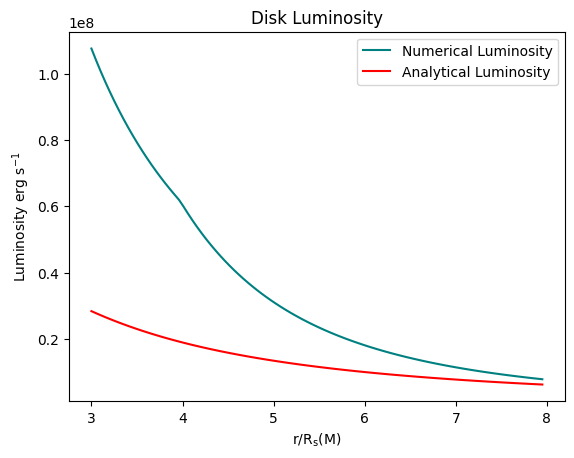

In [16]:
import matplotlib.pyplot as plt

plt.plot(r[0:99],lum, color='teal',label='Numerical Luminosity')
plt.plot(r[0:99],lumana,color='red', label='Analytical Luminosity')
plt.legend()
plt.title("Disk Luminosity")
plt.xlabel('$\mathrm{r/R_s(M)}$')
plt.ylabel('Luminosity erg $\mathrm{s^{-1}}$')

plt.savefig("lumi.png",dpi=300)
files.download("lumi.png") 

In [10]:
def l_ana(a,b,m):
  ra = a*schwarz(m)
  rb = b*schwarz(m)
  mdot = m_edd(m)

  lum = (3*G*m*Msun*mdot/2) * (1/ra*(1-(2/3)*((1/a)**0.5)) - 1/rb*(1-(2/3)*((1/b)**0.5)))
  return lum

In [11]:
lumana = np.array([l_ana(r[i],r[i+1],10) for i in range(len(r)-1)])

In [ ]:
m_edd(10)


In [ ]:
masses = [10,15,20,25,30,35,40]
lum = [ff.luminosity(4,8),ff2.luminosity(4,8),ff3.luminosity(4,8),ff4.luminosity(4,8),ff5.luminosity(4,8),ff6.luminosity(4,8),ff7.luminosity(4,8)]
plt.scatter(masses,lum)
plt.plot(masses,lum)

In [ ]:
ff.luminosity(3,1e7)

In [ ]:
(4*np.pi*G*10*Msun*c*mH)/(sigmaT)

In [13]:
from google.colab import files
#plt.savefig("abc.png")


In [ ]:
plt.plot(ff.r/ff.rg,ff.analytical_middle(0.2)[0],label='$\mathrm{10 M_{\odot}}$')
plt.plot(ff2.r/ff2.rg,ff2.analytical_middle(0.2)[0],label='$\mathrm{15 M_{\odot}}$')
plt.plot(ff3.r/ff3.rg,ff3.analytical_middle(0.2)[0],label='$\mathrm{20 M_{\odot}}$')
plt.plot(ff4.r/ff4.rg,ff4.analytical_middle(0.2)[0],label='$\mathrm{25 M_{\odot}}$')
plt.xlabel('$\mathrm{r/R_s(M)}$')
plt.ylabel('$\mathrm{\Sigma(g/cm^2)}$')
plt.title("Analytical Surface Density")
plt.legend()
plt.savefig("fig1_ana.png",dpi=300)
files.download("fig1_ana.png") 

In [ ]:
3.0e10/0.00040 == 7.5e13

In [ ]:
plt.plot(ff.r/ff.rg,ff.get_sigma_num()[0],label='$\mathrm{10 M_{\odot}}$')
plt.plot(ff2.r/ff2.rg,ff2.get_sigma_num()[0],label='$\mathrm{15 M_{\odot}}$')
plt.plot(ff3.r/ff3.rg,ff3.get_sigma_num()[0],label='$\mathrm{20 M_{\odot}}$')
plt.plot(ff4.r/ff4.rg,ff4.get_sigma_num()[0],label='$\mathrm{25 M_{\odot}}$')
plt.xlabel('$\mathrm{r/R_s(M)}$')
plt.ylabel('$\mathrm{\Sigma(g/cm^2)}$')
plt.title("Numerical Surface Density")
plt.legend()
plt.savefig("fig1_num.png",dpi=300)
files.download("fig1_num.png") 

In [ ]:
#gas pressure
#pgas = (self.rho*kB*self.Tc)/mH

#radiation pressure
#prad = (4*sigmaT*(self.Tc)**4)/(3*c)
plt.plot(ff.r/ff.rg,)

g*cm/s^2 / cm^2

In [ ]:
# ff.r/ff.rg

In [ ]:
plt.plot(ff.r/ff.rg,4*sigmaT*ff.get_tc_num()**4/(3*c),color='red',label="Radiation Pressure")
plt.plot(ff.r/ff.rg,kB*ff.get_rho_num()*ff.get_tc_num()/(mu*mH),color='teal',label="Gas Pressure")
boundary = ff.r[np.argmin(np.abs(4*sigmaT*ff.get_tc_num()**4/(3*c) - kB*ff.get_rho_num()*ff.get_tc_num()/(mu*mH)))]/ff.rg
boundary_15 = ff2.r[np.argmin(np.abs(4*sigmaT*ff2.get_tc_num()**4/(3*c) - kB*ff2.get_rho_num()*ff2.get_tc_num()/(mu*mH)))]/ff2.rg
boundary_20 = ff3.r[np.argmin(np.abs(4*sigmaT*ff3.get_tc_num()**4/(3*c) - kB*ff3.get_rho_num()*ff3.get_tc_num()/(mu*mH)))]/ff3.rg
boundary_25 = ff4.r[np.argmin(np.abs(4*sigmaT*ff4.get_tc_num()**4/(3*c) - kB*ff4.get_rho_num()*ff4.get_tc_num()/(mu*mH)))]/ff4.rg
boundary_30 = ff5.r[np.argmin(np.abs(4*sigmaT*ff5.get_tc_num()**4/(3*c) - kB*ff5.get_rho_num()*ff5.get_tc_num()/(mu*mH)))]/ff5.rg
boundary_35 = ff6.r[np.argmin(np.abs(4*sigmaT*ff6.get_tc_num()**4/(3*c) - kB*ff6.get_rho_num()*ff6.get_tc_num()/(mu*mH)))]/ff6.rg
boundary_40 = ff7.r[np.argmin(np.abs(4*sigmaT*ff7.get_tc_num()**4/(3*c) - kB*ff7.get_rho_num()*ff7.get_tc_num()/(mu*mH)))]/ff7.rg


plt.scatter(boundary,(4*sigmaT*ff.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff.get_tc_num()**4/(3*c) - kB*ff.get_rho_num()*ff.get_tc_num()/(mu*mH)))], color = 'k', s = 10*2)
plt.scatter(boundary_15,(4*sigmaT*ff2.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff2.get_tc_num()**4/(3*c) - kB*ff2.get_rho_num()*ff2.get_tc_num()/(mu*mH)))], color = 'k', s = 15*2)
plt.scatter(boundary_20,(4*sigmaT*ff3.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff3.get_tc_num()**4/(3*c) - kB*ff3.get_rho_num()*ff3.get_tc_num()/(mu*mH)))], color = 'k', s = 20*2)
plt.scatter(boundary_25,(4*sigmaT*ff4.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff4.get_tc_num()**4/(3*c) - kB*ff4.get_rho_num()*ff4.get_tc_num()/(mu*mH)))], color = 'k', s = 25*2)
plt.scatter(boundary_30,(4*sigmaT*ff5.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff5.get_tc_num()**4/(3*c) - kB*ff5.get_rho_num()*ff5.get_tc_num()/(mu*mH)))], color = 'k', s = 30*2)
plt.scatter(boundary_35,(4*sigmaT*ff6.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff6.get_tc_num()**4/(3*c) - kB*ff6.get_rho_num()*ff6.get_tc_num()/(mu*mH)))], color = 'k', s = 35*2)
plt.scatter(boundary_40,(4*sigmaT*ff7.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff7.get_tc_num()**4/(3*c) - kB*ff7.get_rho_num()*ff7.get_tc_num()/(mu*mH)))], color = 'k', s = 40*2)


variation = np.array([(4*sigmaT*ff.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff.get_tc_num()**4/(3*c) - kB*ff.get_rho_num()*ff.get_tc_num()/(mu*mH)))],
                      (4*sigmaT*ff2.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff2.get_tc_num()**4/(3*c) - kB*ff2.get_rho_num()*ff2.get_tc_num()/(mu*mH)))],
                      (4*sigmaT*ff3.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff3.get_tc_num()**4/(3*c) - kB*ff3.get_rho_num()*ff3.get_tc_num()/(mu*mH)))],
                      (4*sigmaT*ff4.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff4.get_tc_num()**4/(3*c) - kB*ff4.get_rho_num()*ff4.get_tc_num()/(mu*mH)))],
                       (4*sigmaT*ff5.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff5.get_tc_num()**4/(3*c) - kB*ff5.get_rho_num()*ff5.get_tc_num()/(mu*mH)))],
                      (4*sigmaT*ff6.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff6.get_tc_num()**4/(3*c) - kB*ff6.get_rho_num()*ff6.get_tc_num()/(mu*mH)))],
                      (4*sigmaT*ff7.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff7.get_tc_num()**4/(3*c) - kB*ff7.get_rho_num()*ff7.get_tc_num()/(mu*mH)))]])



plt.axvline(boundary, linestyle = '--')

plt.ylabel('$\mathrm{Pressure(g cm^{-1} s^{-2})}$')
plt.xlabel('$\mathrm{r/R_s(M)}$')
#plt.fill_between(np.array(ff.r/ff.rg),0,1)
plt.fill_betweenx([0, 6000], 4, boundary, color='red', alpha=0.2)
plt.fill_betweenx([0, 6000], boundary, 8, color='teal', alpha=0.2)
plt.text(boundary + 0.05, 2900, "Dividing Line",rotation = 90)
plt.scatter(boundary,(4*sigmaT*ff.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff.get_tc_num()**4/(3*c) - kB*ff.get_rho_num()*ff.get_tc_num()/(mu*mH)))], color = 'k', s = 10)
plt.plot([boundary,boundary_15,boundary_20,boundary_25,boundary_30,boundary_35,boundary_40], variation, linestyle = '--', label = "$\mathrm{R_{boundary}}$ vs $\mathrm{P_{boundary}}$ for linearly scaled BH Mass")
plt.text(6.0,3000, "Gas Pressure Dominated")
plt.text(4.3,500, "Radiation Pressure Dominated", rotation = 90, fontsize = 10)
plt.xlim(4,8)
plt.ylim(0,6000)
plt.legend(fontsize = 8, loc= "upper center")
plt.title("Numerical Pressure for M = $10 M_{\odot}$")
plt.savefig("fig2_num.png",dpi=300)
files.download("fig2_num.png") 
#plt.plot(ff2.r/ff2.rg,ff2.get_tc_num()**4,color='red')

In [ ]:
boundary_15

In [ ]:
(4*sigmaT*ff2.get_tc_num()**4/(3*c))[np.argmin(np.abs(4*sigmaT*ff2.get_tc_num()**4/(3*c)*1e16 - kB*ff2.get_rho_num()*ff2.get_tc_num()/(mu*mH)))]*1e16

In [ ]:
# ((3*ff.get_rho_num()*kB*c)/(4*mu*mH*sigmaT))**(1/3)

In [ ]:
# ff.get_tc_num()

In [ ]:
((3*ff.rho*kB*c)/(4*mu*mH*sigmaT))**(1/3)

In [ ]:
ff.luminosity(4,5)

In [ ]:
ff.luminosity(4,5)

In [ ]:
23630433.144573964/ff.rg

In [ ]:
ff.get_bdry()[0]/ff.rg

In [ ]:
a,b = ff.get_energy()

In [ ]:
ff.tc_num(4*ff.rg)

In [ ]:
ff.get_tc_num()[0]

In [ ]:
ff.tc_num(6)

In [ ]:
v,dr,sig,r,rarray = ff.energy(8)

In [ ]:
vall = 5
sigma = sig[np.argmin(np.abs(ff.r / ff.rg - 5))]

In [ ]:
np.argmin(np.abs(ff.r / ff.rg - 5))

In [ ]:
plt.plot(np.linspace(4,4.001,1000),ff.testing())

In [ ]:
energy = ff.get_energy()
energy

In [ ]:
energy[1]

In [ ]:
# ff.get_sigma_num()[1] < 5907608.286143491

In [ ]:
ff.get_bdry()[0]/schwarz(10)

In [ ]:
tau = ff.get_sigma_num()

In [ ]:
ff.tc_num()

In [ ]:
tc = ff.get_tc_num()
tc

In [ ]:
np.shape(tc)

In [ ]:
bdry,fff=ff.get_bdry()

In [ ]:
bdry/schwarz(10)

In [ ]:
fff / schwarz(10)

In [ ]:


jj = []
rr = np.arange(4,10,1)
light = np.array([ff.luminosity(3,i) for i in rr])
plt.plot(rr,light)
plt.xlabel(r"${R}/{R_{Schwarz}(M)}$")
plt.ylabel("Luminosity")

PLOT 2 - luminosity - as you get further away, the luminosity increases - it's cummulative luminosity 

In [ ]:
np.argmin([2,1,3])

In [ ]:
ff.energy(3)

In [ ]:
jj = []
rr = np.arange(4,10,1)
light = np.array([ff.energy(i) for i in rr])
plt.plot(rr,light)
plt.xlabel(r"${R}/{R_{Schwarz}(M)}$")
plt.ylabel("Luminosity")

In [ ]:
#ff.energy(3)
#ff.energy(np.array([1,2,3]))
ff.luminosity(3,4)

In [ ]:
ff.numerical_middle_sigma(7,8)

In [ ]:
ff.luminosity(3,4)

In [ ]:
G*10*Msun*m_edd(10) / 2*schwarz(10)

In [ ]:
a,b,c = ff.energy(3)

In [ ]:
#testing if dr is a smooth function or not; will use an appropriate integration method based on that

import numpy as np
import matplotlib.pyplot as plt
def fg(R):
  G = 1
  m = 1
  mdot = 1

  ds = (3*G*m*mdot)/(8*np.pi*R**3) * (1 - (1/R)**0.5)
  return ds

r = np.linspace(4,20,1000)
dd = fg(r)
plt.plot(r,dd)

In [ ]:
def q(m,mdot,r):
    rstar = 3
    tt = 3*(1-(rstar/r**0.5)) / (8*np.pi*r**3)
    return tt

In [ ]:
rr = np.linspace(1,100,1000)
y = q(10,m_edd(10),rr)
plt.plot(rr,y)

In [ ]:
import numpy
M, M_dot, nu, r_out, r_in=3